# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [215]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier # Решающее дерево
from sklearn.model_selection import train_test_split # Для разделения данных
from sklearn.metrics import accuracy_score # Для расчета точности
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [216]:
RANDOM_STATE: Final[int] = 45

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [217]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [218]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

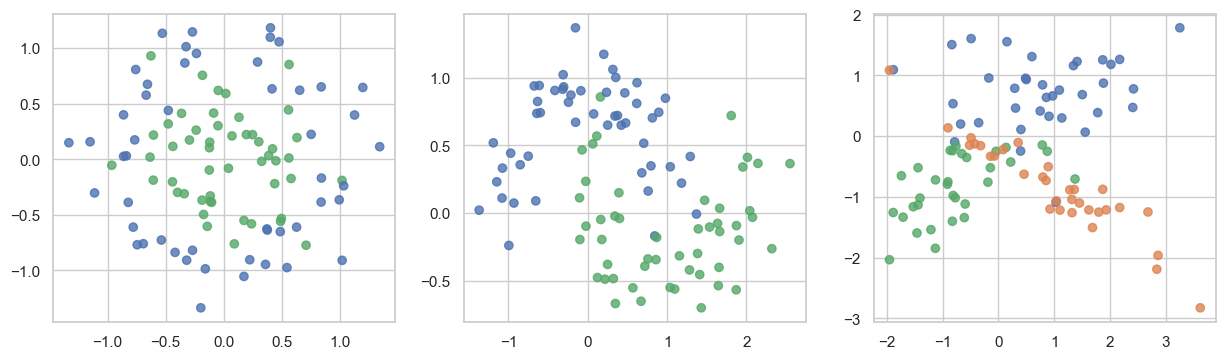

In [219]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

Подсказка для меня.

Datasets:
1. make_circles: получаем круги (как в дартсе). Точки одного класса лежат во внутреннем круге, а точки другого класса — во внешнем кольце;
 2. make_moons: получаем две дуги или "полумесяца", которые смотрят в разные стороны и немного переплетаются;
 3. make_classification: получаем точки, которые группируются в виде "облаков".

Параметры:
 - noise [0.0, 1.0]: чем больше noise, тем сильнее точки "размазываются" вокруг своего идеального положения на дуге или окружности.
 - factor [0.0, 1.0]: соотношение радиуса внутренней окружности к радиусу внешней.
 - random_state [N?]: "начальное состояние" генератора случайных чисел.
 - n_classes [N?]: кол-во классов
 - n_clusters_per_class [N?]: сколько "облаков" или сгустков точек будет представлять каждый класс.
 - n_features [N?]: количество признаков (измерений) для каждой точки данных. В данном случае (X, Y)?
 - class_sep [0.0, inf]: насколько далеко "облака" разных классов расположены друг от друга. Больше - дальше.
 - n_redundant [N?]: количество "избыточных" признаков. Избыточный признак — это признак, который может быть вычислен из других признаков.

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [220]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

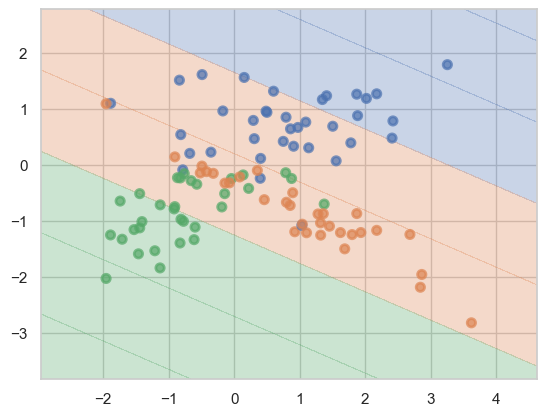

In [221]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

In [222]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

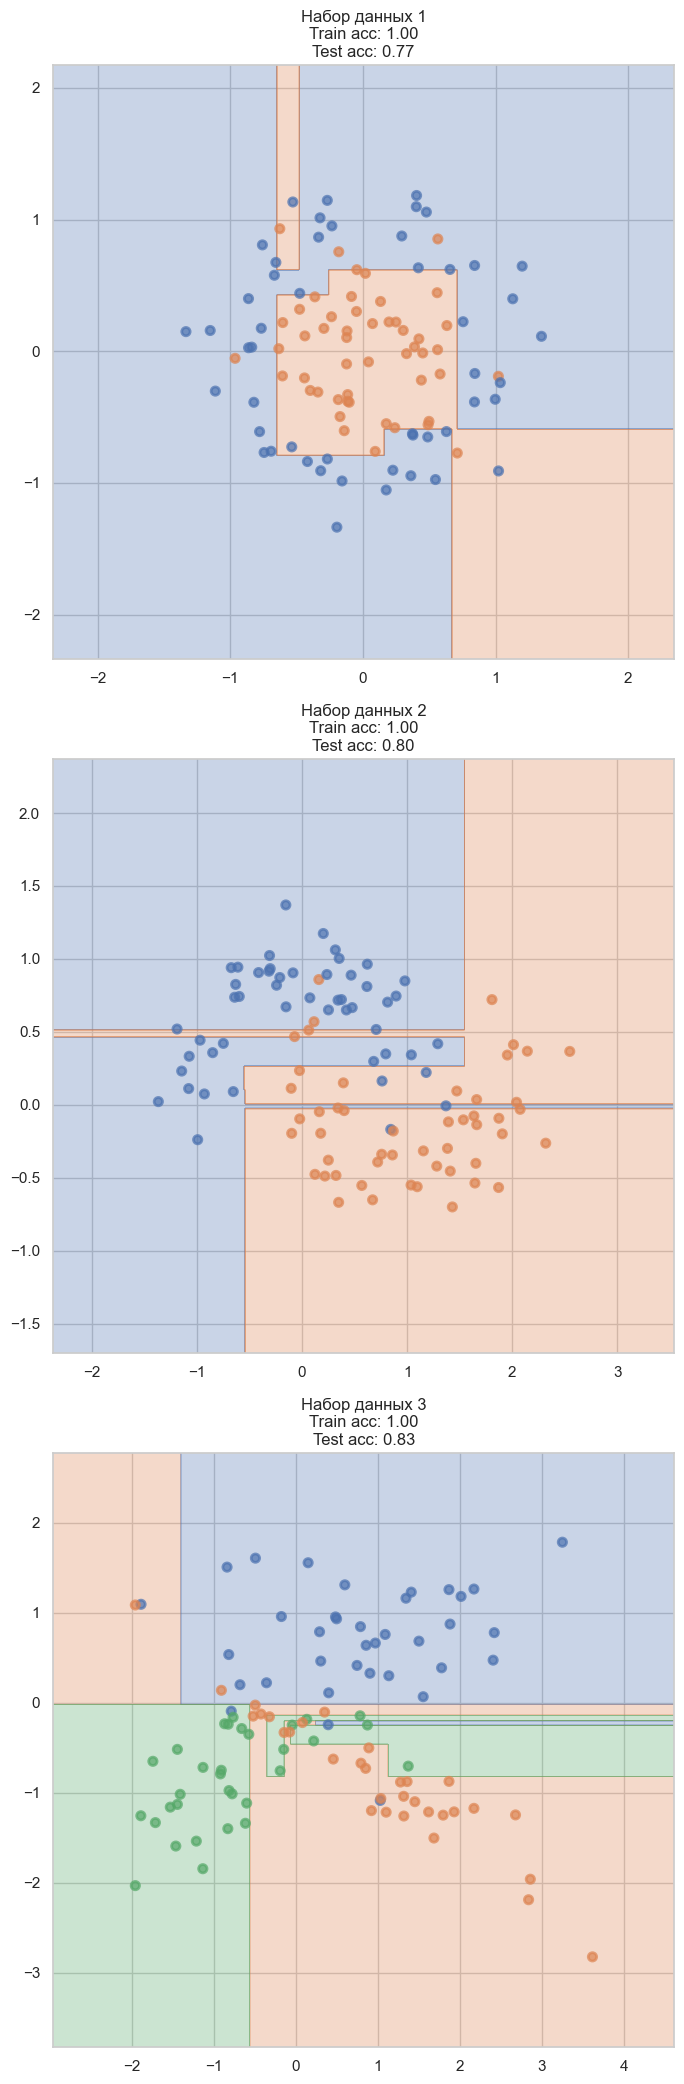

In [223]:
from typing import Final

# для воспроизводимости
plt.figure(figsize=(7, 21))

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

    # Обучаем
    tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
    tree.fit(X_train, y_train)

    # Предсказываем
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)
    
    # Accuracy    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Подграфики
    plt.subplot(3, 1, i + 1)
    plt.title(f'Набор данных {i + 1}\nTrain acc: {train_accuracy:.2f}\nTest acc: {test_accuracy:.2f}')

    # Plot_surface
    plot_surface(tree, X, y)

plt.tight_layout()
plt.show()

__Личные наблюдения__:
  - На первых двух графиках закрашенные области имеют более сложные формы
  - На первых двух dataset'ах тестовая точность ниже (ну и 1.00 (либо близкое к нему) в train, что ожидаемо)

__Ответ:__
  - __Первые 2__ набора данных: __Деревья переобучились__, создав сложные границы, чтобы включить "noise" точки. Видно по детальным ("рваным") границам. Train acc близок либо равен 1, а в то же время Test 0.7 < acc < 0.9.
  - __3 набор__ данных: Границы менее сложные, что заметно как на графике, так и отражено в Test acc > 0.8. __Переобучение__ присутствует, но оно __меньее выражено.__

Можно сделать вывод, что __Решающее Дерево__ из SKLEARN строится до тех пор, пока не достигнет макс. глубины или каждый лист не будет содержать точки одного класса. Т.е. будет пытаться добиться 100% на обуч. выборке, что сказывается на границе. __Это приводит к переобучению на шумных или нелинейно разделимых данных.__

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

In [224]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [225]:
params_dict = [
    {'max_depth': 3, 'min_samples_leaf': 1, 'name': 'MaxDepth: 3, MinLeaf: 1'},
    {'max_depth': 6, 'min_samples_leaf': 4, 'name': 'MaxDepth: 6, MinLeaf: 4'},
    {'max_depth': None, 'min_samples_leaf': 8, 'name': 'MaxDepth: None, MinLeaf: 8'},
]

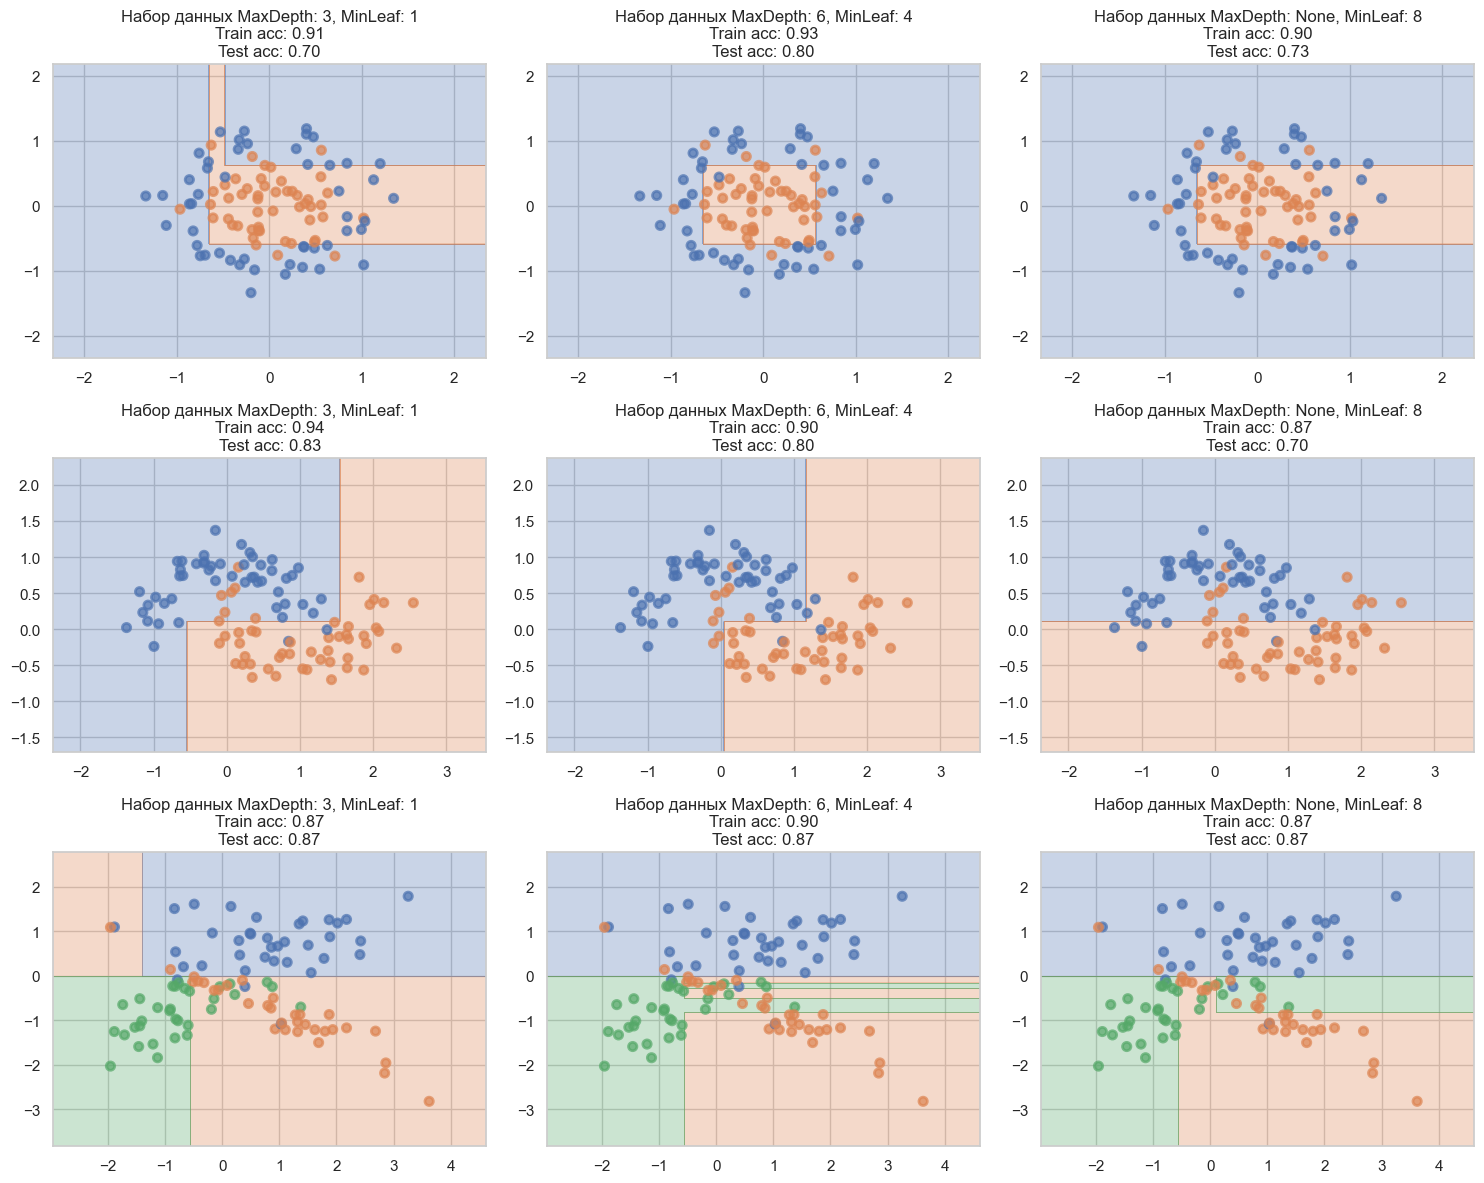

In [226]:
from typing import Final

# для воспроизводимости
fig, axes = plt.subplots(len(datasets), len(params_dict), figsize=(15, 12))

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

    for j, params in enumerate(params_dict):

        max_depth = params['max_depth']
        min_samples_leaf = params['min_samples_leaf']
        name = params['name']
    
        # Обучаем
        tree = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=RANDOM_STATE
        )
        tree.fit(X_train, y_train)
    
        # Предсказываем
        y_train_pred = tree.predict(X_train)
        y_test_pred = tree.predict(X_test)
        
        # Accuracy    
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
    
        # Подграфики
        plt.sca(axes[i, j])
        plt.title(f'Набор данных {name}\nTrain acc: {train_accuracy:.2f}\nTest acc: {test_accuracy:.2f}')
    
        # Plot_surface
        plot_surface(tree, X, y)

plt.tight_layout()
plt.show()

__Личные наблюдения:__ (Эстетически) при RANDOM_STATE = 42
 - Для Circles лучше справились "MaxDepth: 6, MinLeaf: 4" (2)
 - Для Moons лучше справились "MaxDepth: 3, MinLeaf: 1" (1) либо же (3). Но все равное не идеально (не смог передать форму полумесяца). 
 - Для 3 набора данных лучше справились "MaxDepth: None, MinLeaf: 8" (3)

__Ответ:__
  1. Разделяющая поверхность:
     - Для (max_depth=3) Форма областей грубая, старается повторить форму распределения данных, но не пытается следоавать за каждым выбросом.
     - Для (max_depth=6, min_samples_leaf=4) Логично предположить, что границы станут более детализированы с доп. ступеними, изгибами. Лучше адаптируется к форме данных, но как и прежде избегает создания слишком изолированных областей.
     - Для (max_depth=None, min_samples_leaf=[1..8..]) __Границы еще сложнее, особенно где шум/классы расположены близко__. Несмотря на ограниченность min_samples_leaf = 8, дерево все равно может расти достаточно глубоко, что __приводит к ступенькам во круг небольших групп точек. Увеличение min_samples_leaf делает границы более гладкими.__
  3. Обобщающая способность:
     - Для (max_depth=3) не высокая для , особенно для первых 2 datasets, поскольку дерево недостаточно сложное. Присуще underfitting.
     - Для (max_depth=6, min_samples_leaf=4) В Train\Test возрастает. В Test Acc похоже, что стремится показать макс. результат по сравнению с остальными. __Возможно это "золотая середина", где модель достаточно сложна для обучения, но не слишком сложная для обобщения.__
     - Для (max_depth=None, min_samples_leaf=[1..8..]) Чем ниже второй параметр, тем выше Train Acc. и хуже обобщ. способность. Увеличение min_samples_leaf уменьшает переобученность, однако __эфф. неограниченности max_depth доминирует.__
  5. Почему так происходит:
     - max_depth: ограничивает кол-вол проверок признаков. __Неглубокое дерево задает мало "вопросов"__, тем самым быстро разделяя данные на большие, грубые регионы. Глубокие в свою очередь, изолирует маленькие группы точек, что полезно для запоминания обучеия, но плохо для обобщения.
     - min_samples_leaf: ограничивает порог кол-ва точек. Ветка не будет дальше делиться, если численность в потенц. листе станет меньше, что __мешает создавать листья для малого кол-ва (шумных) точек. Менее чувствительно к выбросам.__
  6. Одинаково ли изменение для разных датасетов:
     - Основные сведения:
       1. Влияние параметров не совсем одинаково, но общие тенденции сохраняются:
       2. Простая модель = недообучение\небольшое переобучение
       3. Сложная модель = переобучение
     - Первые 2 набора данных: для этих шумных данных (нелинейно разделимых) Решающее Дерево "MaxDepth: None, MinLeaf: 1" __(*)__ сильно переобучается. Влияние ограниченности max_depth и увеличение min_samples_leaf значимо. Снижает Train Acc, но повышает Test Acc, что полезно.
     - 3 набор данных: В зависимости от разделения "облаков" Решающее Дерево (*) покажет меньшую степень переобученности. Но влияение регуляризации есть: простые деревья дадут грубые границы; ограничение сложности, наверное, немного снизит переобучение (повысит Test Acc).

Как итог, параметры регуляризации помогают добиться баланса между способностью запоминать train данные и обобщать их на новые.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

Под критерием Джини здесь подразумевается следующая функция:
$$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
$R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
$H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

Указания:
* Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
* В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
* Поведение функции в случае константного признака может быть любым.
* При одинаковых приростах Джини нужно выбирать минимальный сплит.
* За наличие в функции циклов балл будет снижен. Векторизуйте! :)


In [227]:
import numpy as np
from collections import Counter

In [228]:
def find_best_split(feature_vector, target_vector):
    """
    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

    n_objects = len(feature_vector)

    # Тривиальный случай
    if n_objects < 2:
        return np.array([]), np.array([]), None, None

    # Сортировка для того, чтобы соседние эл. были точками, между которыми может проходить разделяющий порог (потенциально)    
    dtype = [('feature', feature_vector.dtype), ('target', target_vector.dtype)]
    data = np.empty(n_objects, dtype=dtype)
    data['feature'], data['target'] = feature_vector, target_vector

    sorted_data = np.sort(data, order='feature')
    sorted_feature, sorted_target = sorted_data['feature'], sorted_data['target']

    feature_change_mask = sorted_feature[:-1] != sorted_feature[1:]

    # Проверка прзнака на константность (нет изменений)
    if not np.any(feature_change_mask):
        return np.array([]), np.array([]), None, None

    split_indices = np.where(feature_change_mask)[0]
    thresholds = (sorted_feature[split_indices] + sorted_feature[split_indices + 1]) / 2.0

    cum_class_0, cum_class_1 = np.cumsum(sorted_target == 0), np.cumsum(sorted_target == 1)

    # Обш. кол-во объектов каждого класса
    total_class_0, total_class_1 = cum_class_0[-1], cum_class_1[-1]
    
    n_left_0_all, n_left_1_all = cum_class_0[split_indices], cum_class_1[split_indices]
    n_right_0_all, n_right_1_all = total_class_0 - n_left_0_all, total_class_1 - n_left_1_all

    # Кол-во объектов в левой и правой части
    n_left_all = split_indices + 1
    n_right_all = n_objects - n_left_all

    with np.errstate(divide='ignore', invalid='ignore'):
        ginis_left_all = 1.0 - (n_left_0_all / n_left_all)**2 - (n_left_1_all / n_left_all)**2
        ginis_right_all = 1.0 - (n_right_0_all / n_right_all)**2 - (n_right_1_all / n_right_all)**2

    ginis_Q = -(n_left_all / n_objects) * ginis_left_all - (n_right_all / n_objects) * ginis_right_all

    best_ginis_index = np.argmax(ginis_Q)
    threshold_best = thresholds[best_ginis_index]
    ginis_best = ginis_Q[best_ginis_index]
    
    return thresholds, ginis_Q, threshold_best, ginis_best

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [237]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df = pd.read_csv('students.csv')
print(df.head())

    STG   SCG   STR   LPR   PEG  UNS
0  0.00  0.00  0.00  0.00  0.00    0
1  0.08  0.08  0.10  0.24  0.90    1
2  0.06  0.06  0.05  0.25  0.33    0
3  0.10  0.10  0.15  0.65  0.30    1
4  0.08  0.08  0.08  0.98  0.24    0


In [238]:
feature_columns = df.columns[:-1].tolist()
target_column = df.columns[-1]

# X - Признаки, y - целевая переменная
X = df[feature_columns]
y = df[target_column].values

Признак STG: Лучший порог = 0.6150, Макс Gini Gain: -0.4540
Признак SCG: Лучший порог = 0.4250, Макс Gini Gain: -0.4650
Признак STR: Лучший порог = 0.3650, Макс Gini Gain: -0.4673
Признак LPR: Лучший порог = 0.3900, Макс Gini Gain: -0.4547
Признак PEG: Лучший порог = 0.3350, Макс Gini Gain: -0.0861


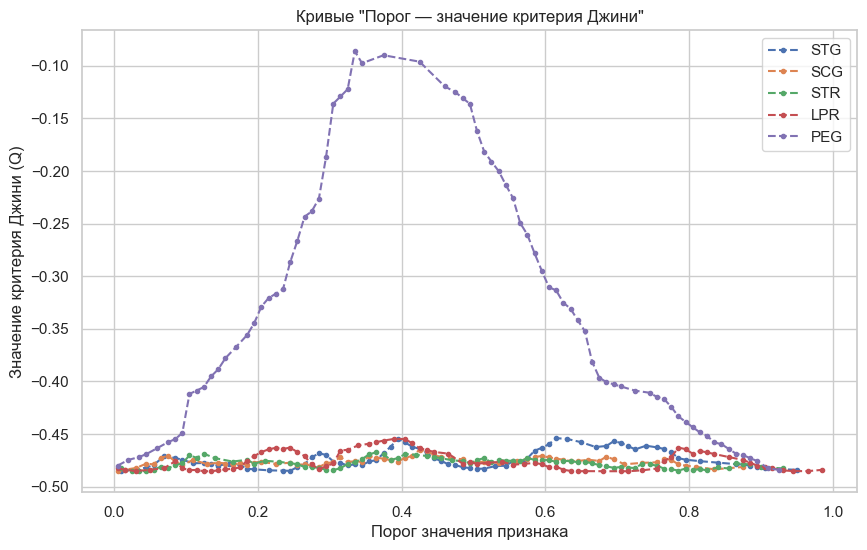

In [239]:
plt.figure(figsize=(10,6))
plt.title('Кривые "Порог — значение критерия Джини"')
plt.xlabel('Порог значения признака')
plt.ylabel('Значение критерия Джини (Q)')
plt.grid(True)

gini_results = {}
for feature in feature_columns:
    feature_vec = X[feature].values
    thresholds, ginis_Q, best_threshold, best_gini_gain = find_best_split(feature_vec, y)

    if len(thresholds) > 0:
        plt.plot(thresholds, ginis_Q, linestyle='--', marker='o', markersize=3, label=feature)

        print(f'Признак {feature}: Лучший порог = {best_threshold:.4f}, Макс Gini Gain: {best_gini_gain:.4f}')
            
    gini_results[feature] = (thresholds, ginis_Q)

plt.legend()
plt.show()

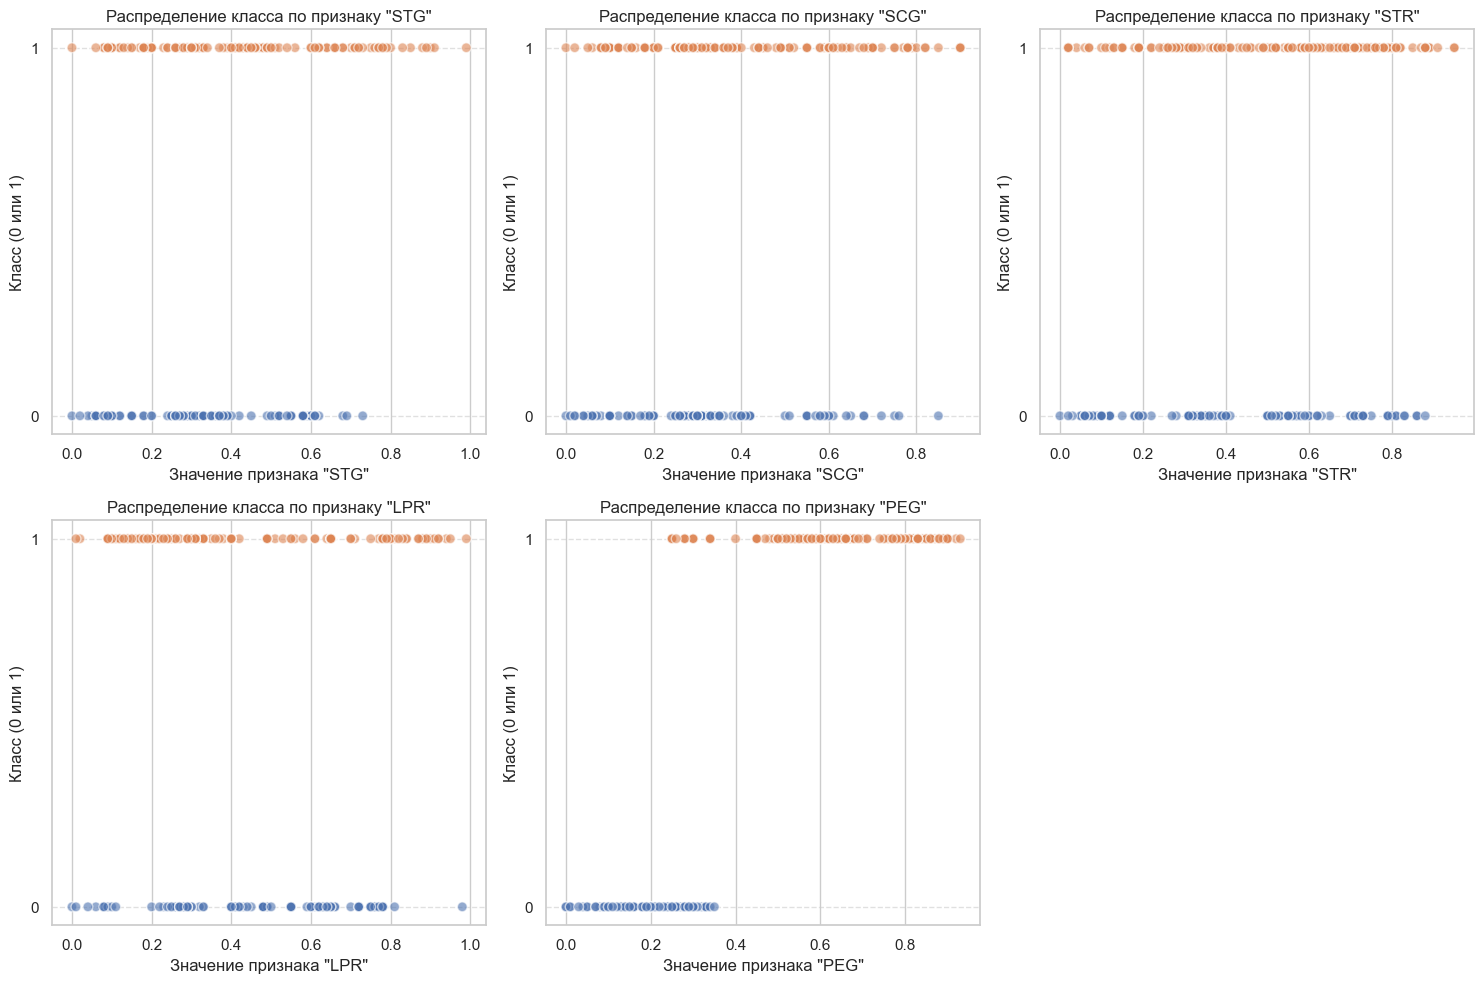

In [66]:
palette = sns.color_palette(n_colors=2)
cmap = ListedColormap(palette)

plt.figure(figsize=(15, 10))

for i, feature in enumerate(feature_columns):
    plt.subplot(2, 3, i + 1)

    feature_vec = X[feature].values

    plt.scatter(feature_vec, y, c=y, cmap=cmap, alpha=0.6, edgecolors='w', s=50)

    plt.title(f'Распределение класса по признаку "{feature}"')
    plt.xlabel(f'Значение признака "{feature}"')
    plt.ylabel('Класс (0 или 1)')
    plt.yticks([0, 1])
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**
  - Деление нужно производить по PEG (кривая достигает макс. значения по сравнению с др.). Т.е. можно найти порог, который макс. снижает неопределенность после разбиения.
  - Согласуется. Точки разных классов наиболее явно разделены вдоль оси признака. Можно провести верт. линию (условно), которая хорошо отделяет точки одного класса от другого.
  - Могу предположить у этой кривой будет высокий пик (хоршо выраженный). Значение будет приблежаться к максимально возможному.
  - Исходя из предыдщего пункта, предположу, что кривая будет плоской и низкой.

Для справки (из интернета):
  - Кривая для "хороших" признаков: значения в пике близко к равному изначальной неопределенности во всем родительском узле
  - Кривая для "плохих" признаков: Q-значения будут близки к Gini родительского узла

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

In [197]:
# Некоторые ошибки я исправил позже и не пометил меткой "была ошибка". Не помню какие именно, но такие были

class DecisionTree:
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node, cur_depth):
        n_objects = len(sub_y)

        if np.all(sub_y == sub_y[0]): # Была ошибка
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        # Нет проверок условий останова по max_depth, min_samples_split
        # if (self._max_depth is not None and cur_depth >= self._max_depth) or \
        #    (self._min_samples_split is not None and n_objects < self._min_samples_split):
        #     node["type"] = "terminal"
        #     node["class"] = Counter(sub_y).most_common(1)[0][0]
        #     return
        
        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]): # Была ошибка
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    ratio[key] = current_count / current_click if not (current_click == 0) else 0 # Была ошибка
                sorted_categories = list(map(lambda x: x[0], sorted(ratio.items(), key=lambda x: x[1])))
                categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))

                feature_vector = np.array(list(map(lambda x: categories_map[x], sub_X[:, feature])))
            else:
                raise ValueError

            # Была ошибка
            _, _, threshold, gini = find_best_split(feature_vector, sub_y)

            if threshold is None:
                continue
            
            # Нет проверок условий останова по min_samples_leaf
            # num_right = np.sum(~(feature_vector < threshold))
            # num_left = np.sum(feature_vector < threshold)
            # if self._min_samples_leaf is not None and \
            #    (num_left < self._min_samples_leaf or num_right < self._min_samples_leaf):
            #     continue
            
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                split = feature_vector < threshold

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "categorical": # Была ошибка
                    threshold_best = list(map(lambda x: x[0],
                                              filter(lambda x: x[1] < threshold, categories_map.items())))
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0] # Была ошибка
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], cur_depth + 1)
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"], cur_depth + 1) # Была ошибка

    def _predict_node(self, x, node):
        # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        if node["type"] == 'terminal':
            return node["class"]

        feature_idx = node["feature_split"]
        feature_value = x[feature_idx]
        feature_type = self._feature_types[feature_idx]

        if feature_type == 'real':
            threshold = node["threshold"]
            if feature_value < threshold:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
            
        elif feature_type == 'categorical':
            categories_split = node["categories_split"]
            if feature_value in categories_split:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else: 
            raise ValueError(f'Неизвестный тип признака: {feature_type}')
        
    def fit(self, X, y):
        self._fit_node(X, y, self._tree, 0)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

    #Метод для сл. задания (опционально)
    def get_depth(self, node=None):
        if node is None:
            node = self._tree
        if node.get("type") == 'terminal':
            return 1
        if node.get("type") == 'nonterminal':
            left_depth = self.get_depth(node.get("left_child")) if 'left_child' in node else 0
            right_depth = self.get_depth(node.get("right_child")) if 'right_child' in node else 0
            return 1 + max(left_depth, right_depth)
        return 0

    def get_params(self, deep=True):
        return {
            "feature_types": self._feature_types, 
            "max_depth": self._max_depth, 
            "min_samples_leaf": self._min_samples_leaf, 
            "min_samples_split": self._min_samples_split, 
        }

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [111]:
from sklearn.preprocessing import LabelEncoder

In [146]:
df = pd.read_csv('agaricus-lepiota.data', header=None)

In [149]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
label_encoders = {}

for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

unique_classes = np.unique(y)

if len(unique_classes):
    class_map = {unique_classes[0]: 0, unique_classes[1]: 1}
    y = np.array([class_map[label] for label in y])
elif len(unique_classes) > 2:
    raise ValueError('More than 2 class found')

feature_types = ["categorical"] * X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_STATE)

tree = DecisionTree(feature_types=feature_types)
tree.fit(X_train, y_train)

predictions = tree.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
depth = tree.get_depth()

print(f'\nAccuracy на тестовой выборке: {accuracy:.4f}')
print(f'Глубина построенного дерева: {depth}')



Accuracy на тестовой выборке: 0.9990
Глубина построенного дерева: 7


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [156]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder

In [208]:
# Функция загрузки
def load_dataset(path, target_col_idx, has_header=False, target_mapping=None):
    df = pd.read_csv(path, header=(0 if has_header else None))

    if target_col_idx == -1:
        target_col_actual_idx = df.shape[1] - 1
    else:
        target_col_actual_idx = target_col_idx

    y = df.iloc[:, target_col_actual_idx].values
    cols_indices = np.arange(df.shape[1])
    feature = np.delete(cols_indices, target_col_actual_idx)
    X = df.iloc[:, feature].values

    if target_mapping:
        unique_y = np.unique(y)
        y = np.array([target_mapping[label] for label in y])

    return X, y

In [210]:
# Предобработка
def prepare_data(X, y, encoding_type):
    X_le = np.copy(X)

    le = LabelEncoder()

    for i in range(X_le.shape[1]):
        X_le[:, i] = le.fit_transform(X_le[:, i].reshape(-1, 1)).flatten()

    y_le = np.copy(y)
    y_le = le.fit_transform(y_le)

    if encoding_type == 'ohe':
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_le = ohe.fit_transform(X_le)

    feature_types = None

    if encoding_type == 'cat':
        feature_types = ["categorical"] * X_le.shape[1]
    else:
        feature_types = ["real"] * X_le.shape[1]
        
    return X_le, y_le, feature_types

In [187]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# Оценка с помощью кросс-валидации
def evaluate(model, X, y, feature_types=None):
    if isinstance(model, DecisionTree) and feature_types is not None:
        scores = cross_val_score(model, X, y, cv=10, scoring=make_scorer(accuracy_score))
    elif isinstance(model, DecisionTreeClassifier) and feature_types is not None:
        scores = cross_val_score(model, X, y, cv=10, scoring=make_scorer(accuracy_score))
    else:
        raise ValueError

    mean_accuracy = np.mean(scores)
    return mean_accuracy

In [188]:
car_target_mapping = {'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1}
nursery_target_mapping = {'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1}

In [189]:
dataset_configs = {
    'mushrooms': {'file': 'agaricus-lepiota.data', 'target_col': 0, 'mapping': None, 'has_header': False},
    'tic-tac-toe': {'file': 'tic-tac-toe-endgame.csv', 'target_col': -1, 'mapping': None, 'has_header': True},
    'car': {'file': 'car.data', 'target_col': -1, 'mapping': car_target_mapping, 'has_header': False},
    'nursery': {'file': 'nursery.data', 'target_col': -1, 'mapping': nursery_target_mapping, 'has_header': False},
}

In [190]:
alg_configs = {
    'CustomTree (Real)': {'encoding': 'real', 'model_type': 'custom'},
    'CustomTree (Cat)': {'encoding': 'cat', 'model_type': 'custom'},
    'CustomTree (OHE)': {'encoding': 'ohe', 'model_type': 'custom'},
    'Sklearn': {'encoding': 'sklearn', 'model_type': 'sklearn'},
}

In [212]:
results = pd.DataFrame(index=dataset_configs.keys(), columns=alg_configs.keys())

for dataset_name, config in dataset_configs.items():

    X, y = load_dataset(config['file'], config['target_col'], config['has_header'], config['mapping'])

    for alg_name, alg_config in alg_configs.items():
        X_proc, y_proc, feature_types = prepare_data(X, y, alg_config['encoding'])

        if alg_config['model_type'] == 'custom':
            model = DecisionTree(feature_types=feature_types)
            mean_acc = evaluate(model, X_proc, y_proc, feature_types)
        elif alg_config['model_type'] == 'sklearn':
            model = DecisionTreeClassifier(random_state=RANDOM_STATE)
            mean_acc = evaluate(model, X_proc, y_proc, feature_types)
        else:
            raise ValueError

        results.loc[dataset_name, alg_name] = mean_acc

print(f'\nТаблица результатов')
print(results)


Таблица результатов
            CustomTree (Real) CustomTree (Cat) CustomTree (OHE)   Sklearn
mushrooms            0.999261              1.0         0.999631  0.956689
tic-tac-toe          0.467533         0.583147         0.543564  0.753958
car                  0.942647         0.967546         0.919495  0.943285
nursery              0.999691         0.999537         0.999537  0.999691


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**
 1. Ранжирование алгоритмов не является одинаковым. Алгоритмы лидирующие в одних могут проигрывать в других:
    - у __mushrooms__ лучший результат у CustomTree (Cat). Худший у Sklearn (существенно худший)
    - у __tic-tac-toe__ лучший результат у Sklearn. Худший у CustomTree (Real). В целом статистика не самая удовлетворяющая.
    - у __car__ лучший результат у CustomTree (Cat). Худший у CustomTree (OHE).
    - у __nursery__ в принципе все справились довольно хорошо.
 2. Скорее всего это связано с тем, как алгоритмы обрабатывают кат. признаки. Также зависит от внутренней структуры\сложности датасетов.
    - Для обработки признаков как real. Этот подход может показывать низкие показатели, если числовое кодирование не соответствует естественному порядку категорий.
    - __Cat__ в свою очередь группирует на основе их связи с целевой переменной, что позволяет добиться более эфф. результатов (ищет более осмысленные бинарные разделения). Успех в __mushrooms и car__ предполагает, что он быстро нашел правила разделения. Скорее всего метод разделения категорий по отношению цел. класса очень хорошо соответсвует структуре датасетов. 
    - __OHE__ увеличивает размерность пространства, приобразуя каждую категорию в отдельный бинарный признак (избегает ординарности). Производительность сильно варьируется. Значит что выбор между простым ординальным представление и OHE также зависит от датасета. 
    - __Sklearn__ скорее всего имеет более продвинутые стратегии поиска разбиения, что иногда дает ей преимущество (оптимизированная реализация). Сильно превосходит остальные в __tic_tac__. Может указывать на то, что оптимизация\подход к работе с числовыми представлениями  лучше улавливает закономерности.
  3. Могу предположить, что компонента случайности присутствует, что приводит к колебаниям точности при повторных запусках (также зависит от фиксированности random_state\shuffle=True). Связано с тем как данные разделяются на тестовые и тренировочные данные в каждом фолде. Также влияет правила разрешения конфликтов, когда несколько вариантов имеют одинаковый критерий разбиения.
  4. Да, можно использовать фиксированное значение random_state для воспроизводимости. Что на счет алгоритмов. То конечно на это влияет гиперпараметры max_depth, min_samples_leaf, min_samples_split. Также влияет (скорее всего) эксперементирование с различными стратегиями (Lable Encoding, OHE и т.п.). Также может помочь градиентый бустинг и прочие доп. методы.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

Словил ошибку в 9 и пришлось весь кода еще более детально изучить. Углубиться в некоторые стези :) 
Также возникла проблема совместимости с ориг. классом вот тут "cross_val_score(model, X, y, cv=10, scoring=make_scorer(accuracy_score))".
Что добавило времени на реализацию. Может я просто где-то ошибся..
______________
Интересно было бы, наверное, визуализацию дерева добавить на доп балл?? Также обработку пропущенных значений.
Может было бы интересно добавить просмотр решений дерева. Взять датасет и обучить, например на __Real__ и __Cat__. После обучения посмотреть какое решение дерево приняло в корне.
Также мне нравится визуализация :)